In [88]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
import scipy.stats as stats

from sklearn.impute import IterativeImputer, SimpleImputer,KNNImputer
from sklearn.tree import DecisionTreeRegressor
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler,MinMaxScaler,LabelEncoder,OrdinalEncoder,OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.experimental import enable_iterative_imputer

from sklearn.metrics import accuracy_score,classification_report,roc_curve, roc_auc_score,plot_confusion_matrix
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings("ignore")

# 1. Reading data and checking for missing values

In [107]:
df = pd.read_csv("train.csv")

In [108]:
df.head()

,Unnamed: 0,ID,ncap rating,is power door locks,policyholder age,is parking camera,rear brakes type,is adjustable steering,is tpms,is driver seat height adjustable,...,is parking sensors,power,gross weight,is day night rear view mirror,model,gear box,airbags,turning radius,area danger level,is claim
0,0,0,2.0,Yes,0.394496,No,Drum,No,No,No,...,Yes,55.92bhp@5300rpm,1340.0,No,Model_8,5.0,2.0,4.7,4,0
1,1,1,2.0,Yes,0.417364,No,Drum,No,No,No,...,Yes,55.92bhp@5300rpm,1340.0,No,Model_8,5.0,2.0,4.7,1,1
2,2,2,2.0,Yes,0.438922,No,Drum,Yes,No,Yes,...,Yes,88.50bhp@6000rpm,1335.0,Yes,Model_6,5.0,2.0,4.8,5,0
3,3,3,0.0,No,0.656276,No,Drum,No,No,No,...,Yes,40.36bhp@6000rpm,1185.0,No,Model_1,5.0,2.0,4.6,2,0
4,4,4,3.0,Yes,0.462328,Yes,Disc,Yes,Yes,Yes,...,Yes,113.45bhp@4000rpm,1720.0,No,Model_4,6.0,6.0,5.2,3,0


In [109]:
df.isnull().sum()

Unnamed: 0                            0
ID                                    0
ncap rating                          99
is power door locks                  94
policyholder age                     81
is parking camera                    83
rear brakes type                     86
is adjustable steering               90
is tpms                              89
is driver seat height adjustable     85
segment                              83
car age                             105
is central locking                   89
is rear window wiper                 69
height                               96
cluster area                         85
is ecw                               85
fuel type                            89
torque                               76
engine volume                       103
transmission type                    97
manufacturer                         87
cylinder                             97
is rear window washer                89
is front fog lights                  86


In [110]:
# Sample columns to use (3 categorical,3 numerical,1 target):

df1 = df[["ncap rating","is power door locks","segment","car age","population","time period","is claim"]]
df1

,ncap rating,is power door locks,segment,car age,population,time period,is claim
0,2.0,Yes,B1,0.08,8883.0,0.304554,0
1,2.0,Yes,B1,0.06,34751.0,1.169197,1
2,2.0,Yes,B2,0.03,27026.0,1.219797,0
3,0.0,No,A,0.04,5482.0,0.746151,0
4,3.0,Yes,C2,0.04,17833.0,0.171981,0
...,...,...,...,...,...,...,...
43587,2.0,Yes,B2,0.05,8828.0,0.125440,0
43588,2.0,Yes,C1,0.11,5455.0,1.177618,0
43589,2.0,Yes,B2,0.15,27082.0,0.601047,0
43590,2.0,Yes,B2,0.14,8845.0,0.442004,0


In [111]:
df1.columns = ["ncap","doorlocks","segment","age","pop","time","claim"]
df1

,ncap,doorlocks,segment,age,pop,time,claim
0,2.0,Yes,B1,0.08,8883.0,0.304554,0
1,2.0,Yes,B1,0.06,34751.0,1.169197,1
2,2.0,Yes,B2,0.03,27026.0,1.219797,0
3,0.0,No,A,0.04,5482.0,0.746151,0
4,3.0,Yes,C2,0.04,17833.0,0.171981,0
...,...,...,...,...,...,...,...
43587,2.0,Yes,B2,0.05,8828.0,0.125440,0
43588,2.0,Yes,C1,0.11,5455.0,1.177618,0
43589,2.0,Yes,B2,0.15,27082.0,0.601047,0
43590,2.0,Yes,B2,0.14,8845.0,0.442004,0


In [112]:
df1.isnull().sum()

ncap          99
doorlocks     94
segment       83
age          105
pop           95
time          82
claim          0
dtype: int64

In [113]:
df_cats = df1[["ncap","doorlocks","segment"]]
df_nums = df1[["age","pop","time"]]

**Although the missing values are not significant in 43592 pieces of data on a per piece basis, we will try to fill them statistically correctly instead of deleting them.**

# 2. Correlation between features and nullity correlation check

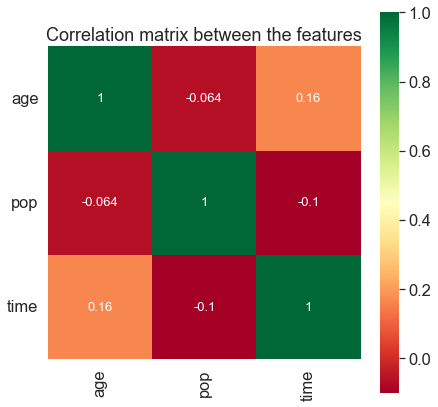

In [114]:
sns.set(font_scale=1.5)  
correlation_matrix = df_nums.corr().astype(float).round(4)
plt.figure(figsize=(7,7))
ax = sns.heatmap(correlation_matrix, vmax=1, square=True,annot=True,cmap='RdYlGn',annot_kws={'size': 13})
plt.title('Correlation matrix between the features')
plt.yticks(rotation=0)
plt.xticks(rotation=90)
plt.show()

**When we check the correlation of numerical data, it seems that they do not have a relationship with each other.**

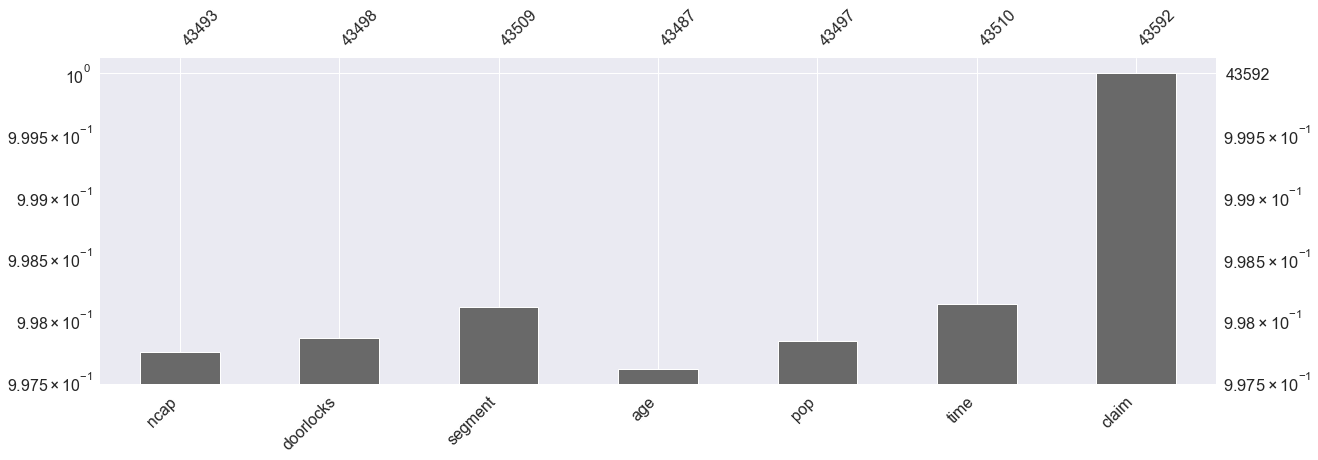

In [115]:
msno.bar(df1, figsize=(20,6),filter="top",log=True);

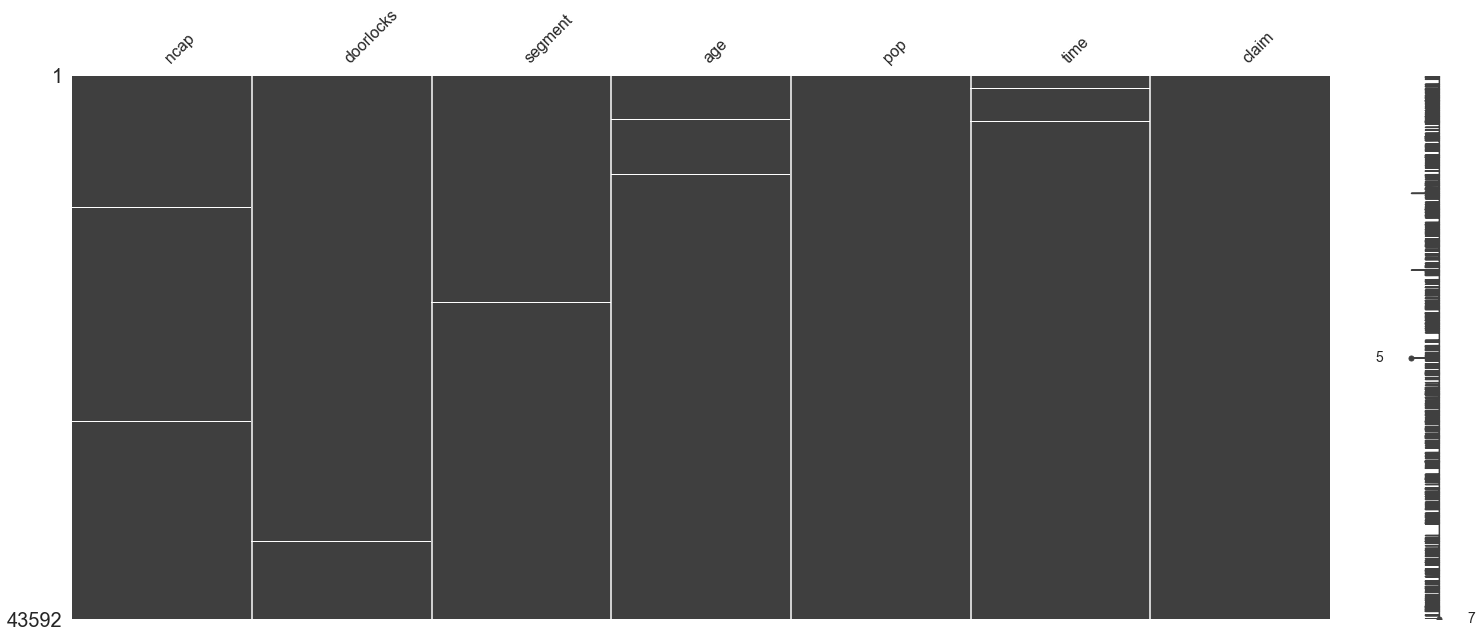

In [116]:
msno.matrix(df1);

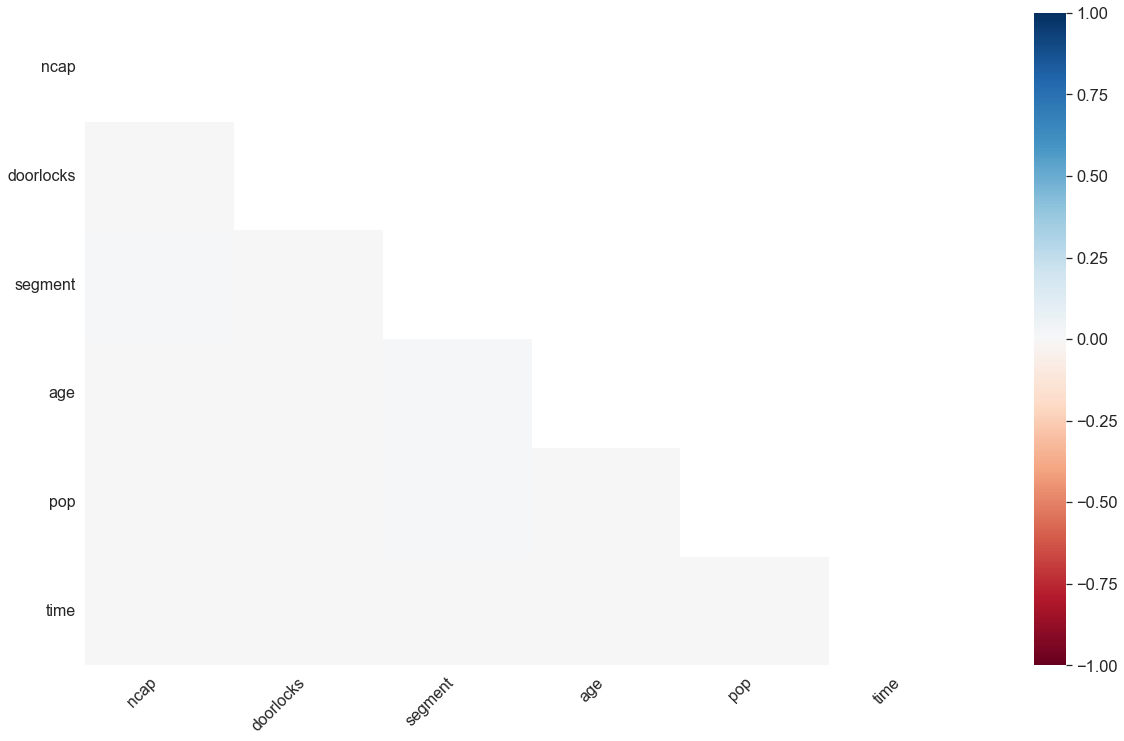

In [117]:
# Presents a `seaborn` heatmap visualization of nullity correlation in the given DataFrame
msno.heatmap(df1);

**As seen in the nullity correlation graph and the matrix, the missing values are not related to each other and are formed randomly.**

# 3. Handling With Missing Values

## <span style="color:blue">3.1. Using the SimpleImputer (Cats-Nums)</span> 

In [118]:
# For the categorical features, we will use "most frequent" strategy.

freq_cats = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
df_cats_imp = pd.DataFrame(freq_cats.fit_transform(df_cats))
df_cats_imp.columns=df_cats.columns
df_cats_imp.index=df_cats.index
df_cats_imp

,ncap,doorlocks,segment
0,2.0,Yes,B1
1,2.0,Yes,B1
2,2.0,Yes,B2
3,0.0,No,A
4,3.0,Yes,C2
...,...,...,...
43587,2.0,Yes,B2
43588,2.0,Yes,C1
43589,2.0,Yes,B2
43590,2.0,Yes,B2


In [119]:
df_cats_imp.isnull().sum()

ncap         0
doorlocks    0
segment      0
dtype: int64

In [120]:
# For the numeric features, we will use "mean" strategy.

mean_nums = SimpleImputer(missing_values=np.nan, strategy='mean')
df_nums_imp = pd.DataFrame(freq_cats.fit_transform(df_nums))
df_nums_imp.columns=df_nums.columns
df_nums_imp.index=df_nums.index
df_nums_imp

,age,pop,time
0,0.08,8883.0,0.304554
1,0.06,34751.0,1.169197
2,0.03,27026.0,1.219797
3,0.04,5482.0,0.746151
4,0.04,17833.0,0.171981
...,...,...,...
43587,0.05,8828.0,0.125440
43588,0.11,5455.0,1.177618
43589,0.15,27082.0,0.601047
43590,0.14,8845.0,0.442004


In [121]:
df_nums_imp.isnull().sum()

age     0
pop     0
time    0
dtype: int64

## <span style="color:blue">3.2. Using the IterativeImputer (Nums only)</span> 

**Estimators: BayesianRidge(),DecisionTreeRegressor(max_features='sqrt', random_state=0),ExtraTreesRegressor(n_estimators=10, random_state=0),KNeighborsRegressor(n_neighbors=15)**

In [122]:
# Num variables:

estimator = DecisionTreeRegressor(random_state=0)
df_filled_nums = IterativeImputer(estimator=estimator).fit_transform(df_nums)
df_filled_nums = pd.DataFrame(df_filled_nums, columns=df_nums.columns)
df_filled_nums

,age,pop,time
0,0.08,8883.0,0.304554
1,0.06,34751.0,1.169197
2,0.03,27026.0,1.219797
3,0.04,5482.0,0.746151
4,0.04,17833.0,0.171981
...,...,...,...
43587,0.05,8828.0,0.125440
43588,0.11,5455.0,1.177618
43589,0.15,27082.0,0.601047
43590,0.14,8845.0,0.442004


In [123]:
df_filled_nums.isnull().sum()

age     0
pop     0
time    0
dtype: int64

## <span style="color:blue">3.3. Using the KNNImputer (Nums only)</span> 

In [124]:
# Num variables:

imputer = KNNImputer(n_neighbors=10,weights='uniform')
df_filled_nums_KNN = imputer.fit_transform(df_nums)
df_filled_nums_KNN = pd.DataFrame(df_filled_nums_KNN, columns=df_nums.columns)
df_filled_nums_KNN

,age,pop,time
0,0.08,8883.0,0.304554
1,0.06,34751.0,1.169197
2,0.03,27026.0,1.219797
3,0.04,5482.0,0.746151
4,0.04,17833.0,0.171981
...,...,...,...
43587,0.05,8828.0,0.125440
43588,0.11,5455.0,1.177618
43589,0.15,27082.0,0.601047
43590,0.14,8845.0,0.442004


In [125]:
df_filled_nums_KNN.isnull().sum()

age     0
pop     0
time    0
dtype: int64

## <span style="color:blue">3.4. Predictions For Categorical Missing Values (ML)</span> 

**We will set up a classification ML for 1 categorical variable with missing values and try to predict them.**

In [126]:
# Prediction for "ncap"
# First, filling the other 2 vars with most frequent values.

cats_2 = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
ncap_ml = pd.DataFrame(cats_2.fit_transform(df_cats[["doorlocks","segment"]]))
ncap_ml.columns=["doorlocks","segment"]
ncap_ml = pd.concat([ncap_ml, df_cats.ncap], axis = 1) 
ncap_ml

,doorlocks,segment,ncap
0,Yes,B1,2.0
1,Yes,B1,2.0
2,Yes,B2,2.0
3,No,A,0.0
4,Yes,C2,3.0
...,...,...,...
43587,Yes,B2,2.0
43588,Yes,C1,2.0
43589,Yes,B2,2.0
43590,Yes,B2,2.0


In [127]:
ncap_ml.isnull().sum()

doorlocks     0
segment       0
ncap         99
dtype: int64

In [128]:
ncap_ml = pd.concat([ncap_ml, df_filled_nums], axis = 1) 

df_with_ncap = ncap_ml[ncap_ml.ncap.notna()]
df_no_ncap = ncap_ml[ncap_ml.ncap.isna()]

In [129]:
class MultiColumnLabelEncoder:
    def __init__(self, columns=None):
        self.columns = columns 
        
    def fit(self, X, y=None):
        self.encoders = {}
        columns = X.columns if self.columns is None else self.columns
        for col in columns:
            self.encoders[col] = LabelEncoder().fit(X[col])
        return self
    
    def transform(self, X):
        output = X.copy()
        columns = X.columns if self.columns is None else self.columns
        for col in columns:
            output[col] = self.encoders[col].transform(X[col])
        return output

    def fit_transform(self, X, y=None):
        return self.fit(X,y).transform(X)

    def inverse_transform(self, X):
        output = X.copy()
        columns = X.columns if self.columns is None else self.columns
        for col in columns:
            output[col] = self.encoders[col].inverse_transform(X[col])
        return output

In [131]:
multi = MultiColumnLabelEncoder(columns=['doorlocks','segment'])
encoded = multi.fit_transform(df_with_ncap)
encoded

,doorlocks,segment,ncap,age,pop,time
0,1,1,2.0,0.08,8883.0,0.304554
1,1,1,2.0,0.06,34751.0,1.169197
2,1,2,2.0,0.03,27026.0,1.219797
3,0,0,0.0,0.04,5482.0,0.746151
4,1,4,3.0,0.04,17833.0,0.171981
...,...,...,...,...,...,...
43587,1,2,2.0,0.05,8828.0,0.125440
43588,1,3,2.0,0.11,5455.0,1.177618
43589,1,2,2.0,0.15,27082.0,0.601047
43590,1,2,2.0,0.14,8845.0,0.442004


In [132]:
X = encoded.drop("ncap", axis=1)
Y = encoded.ncap

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

forest = RandomForestClassifier(n_estimators=45, max_depth=25, random_state=False, 
                                max_features=0.6, min_samples_leaf=3, n_jobs=-1)

forest.fit(X_train, Y_train)

y_pred_train = forest.predict(X_train)
y_pred = forest.predict(X_test)

y_pred_proba = forest.predict_proba(X_test)

accuracy_train = accuracy_score(Y_train, y_pred_train)
accuracy_test = accuracy_score(Y_test, y_pred)

print("ACCURACY: TRAIN=%.4f TEST=%.4f" % (accuracy_train,accuracy_test))

ACCURACY: TRAIN=0.9253 TEST=0.8847


In [134]:
multi2 = MultiColumnLabelEncoder(columns=['doorlocks','segment'])
encoded2 = multi2.fit_transform(df_no_ncap)

encoded2 = encoded2.drop('ncap', axis=1)
prediction = forest.predict(encoded2)

encoded2.insert(0, 'ncap', prediction)
encoded2

,ncap,doorlocks,segment,age,pop,time
126,0.0,0,0,0.04,17879.0,0.527331
731,0.0,0,0,0.01,8828.0,1.133107
1316,2.0,1,1,0.04,21640.0,1.170905
1622,2.0,1,2,0.09,7829.0,0.844531
1969,2.0,1,2,0.02,7819.0,1.302173
...,...,...,...,...,...,...
42624,3.0,1,4,0.04,5421.0,0.471655
42788,2.0,1,2,0.18,34796.0,0.557700
42879,2.0,1,0,0.07,27032.0,1.154294
42955,0.0,0,0,0.01,27079.0,0.837517


In [135]:
encoded2.columns

Index(['ncap', 'doorlocks', 'segment', 'age', 'pop', 'time'], dtype='object')

In [139]:
encoded2 = encoded2[['doorlocks', 'segment', 'ncap','age', 'pop', 'time']]

In [141]:
encoded2

,doorlocks,segment,ncap,age,pop,time
126,0,0,0.0,0.04,17879.0,0.527331
731,0,0,0.0,0.01,8828.0,1.133107
1316,1,1,2.0,0.04,21640.0,1.170905
1622,1,2,2.0,0.09,7829.0,0.844531
1969,1,2,2.0,0.02,7819.0,1.302173
...,...,...,...,...,...,...
42624,1,4,3.0,0.04,5421.0,0.471655
42788,1,2,2.0,0.18,34796.0,0.557700
42879,1,0,2.0,0.07,27032.0,1.154294
42955,0,0,0.0,0.01,27079.0,0.837517


In [145]:
ncap_fulled = pd.concat([encoded, encoded2]) 
ncap_fulled = ncap_fulled.sort_index()

In [146]:
ncap_fulled

,doorlocks,segment,ncap,age,pop,time
0,1,1,2.0,0.08,8883.0,0.304554
1,1,1,2.0,0.06,34751.0,1.169197
2,1,2,2.0,0.03,27026.0,1.219797
3,0,0,0.0,0.04,5482.0,0.746151
4,1,4,3.0,0.04,17833.0,0.171981
...,...,...,...,...,...,...
43587,1,2,2.0,0.05,8828.0,0.125440
43588,1,3,2.0,0.11,5455.0,1.177618
43589,1,2,2.0,0.15,27082.0,0.601047
43590,1,2,2.0,0.14,8845.0,0.442004


### Reverse Transform

In [148]:
inv = multi.inverse_transform(ncap_fulled)
inv

,doorlocks,segment,ncap,age,pop,time
0,Yes,B1,2.0,0.08,8883.0,0.304554
1,Yes,B1,2.0,0.06,34751.0,1.169197
2,Yes,B2,2.0,0.03,27026.0,1.219797
3,No,A,0.0,0.04,5482.0,0.746151
4,Yes,C2,3.0,0.04,17833.0,0.171981
...,...,...,...,...,...,...
43587,Yes,B2,2.0,0.05,8828.0,0.125440
43588,Yes,C1,2.0,0.11,5455.0,1.177618
43589,Yes,B2,2.0,0.15,27082.0,0.601047
43590,Yes,B2,2.0,0.14,8845.0,0.442004


In [149]:
inv.isnull().sum()

doorlocks    0
segment      0
ncap         0
age          0
pop          0
time         0
dtype: int64